# Features engineering

In [ ]:
#Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
#Loading Dataset preprocessed and resampled by hour for analysis and visualization

dataPath = "../data/processed/rhm_household_power_consumption.csv"
dataset = pd.read_csv(dataPath, index_col=0, parse_dates=True)

dataset.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,unmeasured,day_of_week,is_weekend,is_holiday,season,time_of_day
Datetime,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,52.992593,5,1,0,3,2
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,36.953333,5,1,0,3,3
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,38.553889,5,1,0,3,3
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,37.692778,5,1,0,3,3
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778,5,1,0,3,3


In [16]:
def plot_pattern_by_filter(df, column_filter, filter_value, variable='Global_active_power'):
    """
    Filtra el DataFrame por un valor específico en una columna y genera un gráfico de línea para la variable seleccionada.
    
    Parámetros:
    - df: DataFrame con índice datetime y columnas como 'day_of_week', 'season', 'is_holiday', etc.
    - column_filter: str, nombre de la columna para filtrar (ej. 'day_of_week')
    - filter_value: valor para aplicar el filtro (ej. 0 para lunes)
    - variable: str, nombre de la variable a graficar (por defecto 'Global_active_power')
    """
    # Filtrado
    df_filtered = df[df[column_filter] == filter_value]
    
    # Agrupación por hora del día si existe la columna correspondiente
    if 'hour' in df_filtered.columns:
        grouped = df_filtered.groupby('hour')[variable].mean()
        x_label = 'Hour of Day'
    else:
        grouped = df_filtered[variable]
        x_label = column_filter
    
    # Gráfico
    plt.figure(figsize=(10, 5))
    #plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='steelblue')
    plt.plot(grouped.index, grouped.values, color='steelblue')
    plt.title(f'{variable} Pattern - {column_filter} = {filter_value}')
    plt.xlabel(x_label)
    plt.ylabel(variable)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

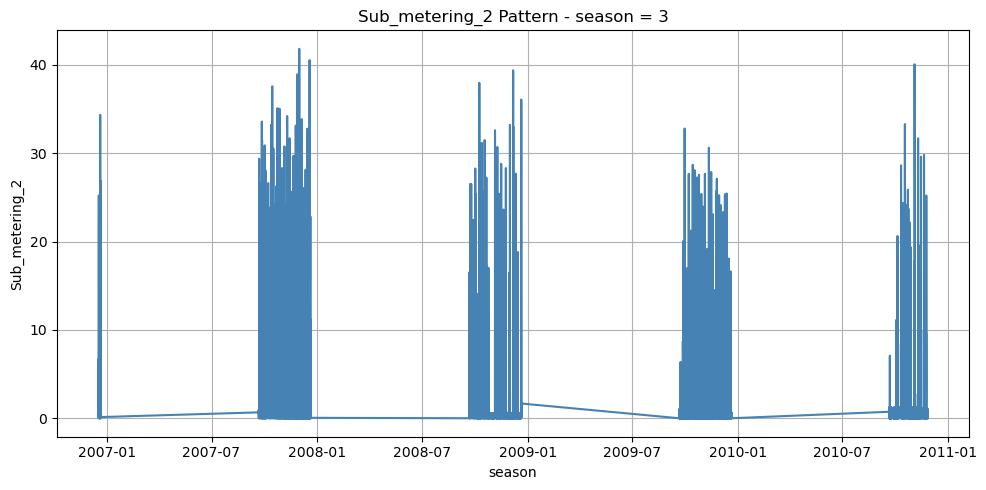

In [19]:
plot_pattern_by_filter(dataset, column_filter ='season', filter_value = 3, variable= 'Sub_metering_2')

### Transformación de los datos para realizar feature engineering

In [10]:
def clean_and_log_transform(X):
    X = X.copy()
    # Reemplaza valores negativos con cero si lo consideras apropiado
    X[X < 0] = 0
    
    # Aplicamos log1p y manejamos valores infinitos
    X_log = np.log1p(X)
    X_log = np.where(np.isfinite(X_log), X_log, 0)  # reemplaza inf o nan con 0
    return X_log

def build_statistical_pipeline():
    # Transformación logarítmica segura (log1p = log(1+x))
    log_transform = FunctionTransformer(clean_and_log_transform, validate=False)

    # Normalización (Z-score)
    scaler = StandardScaler()

    # Construcción del pipeline
    pipeline = Pipeline([
        ('log_transform', log_transform),
        ('scaler', scaler)
    ])
    return pipeline

In [20]:
features = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3',
    'unmeasured'
]

In [24]:
pipeline = build_statistical_pipeline()
X = dataset[features].copy()
X_transformed = pipeline.fit_transform(X)

# Crear DataFrame transformado
df_transformed = pd.DataFrame(
    X_transformed,
    index=dataset.index,
    columns=[f"{col}_scaled" for col in features]
)

# Normalización (Z-score)
scaler = StandardScaler()
df_rhm_scaled = scaler.fit_transform(dataset)

In [25]:
df_transformed.head(10)

,Global_active_power_scaled,Global_reactive_power_scaled,Voltage_scaled,Global_intensity_scaled,Sub_metering_1_scaled,Sub_metering_2_scaled,Sub_metering_3_scaled,unmeasured_scaled
Datetime,,,,,,,,
2006-12-16 17:00:00,2.561101,1.602495,0.067991,2.233582,-0.366222,0.003340,1.296467,2.849662
2006-12-16 18:00:00,2.254498,-0.633315,0.067542,2.016211,-0.366222,2.526417,1.296736,2.323542
2006-12-16 19:00:00,2.123257,-0.550202,0.058010,1.910307,-0.366222,0.728448,1.287797,2.385196
2006-12-16 20:00:00,2.045649,-0.712535,0.063951,1.850534,-0.366222,-0.656907,1.292684,2.352342
2006-12-16 21:00:00,1.915450,-0.687338,0.085627,1.757419,-0.366222,-0.114290,1.313551,2.172813
2006-12-16 22:00:00,1.309700,-1.019984,0.096760,1.309942,-0.366222,-0.461919,0.265001,2.119421
2006-12-16 23:00:00,1.196646,-0.771652,0.109597,1.214808,-0.366222,-0.532211,-1.201977,2.214381
2006-12-17 00:00:00,1.042624,-0.278102,0.111948,1.089303,-0.366222,-0.060255,-1.201977,2.064568
2006-12-17 01:00:00,2.093573,0.255111,0.108418,1.884439,-0.366222,4.432703,-1.201977,2.049628


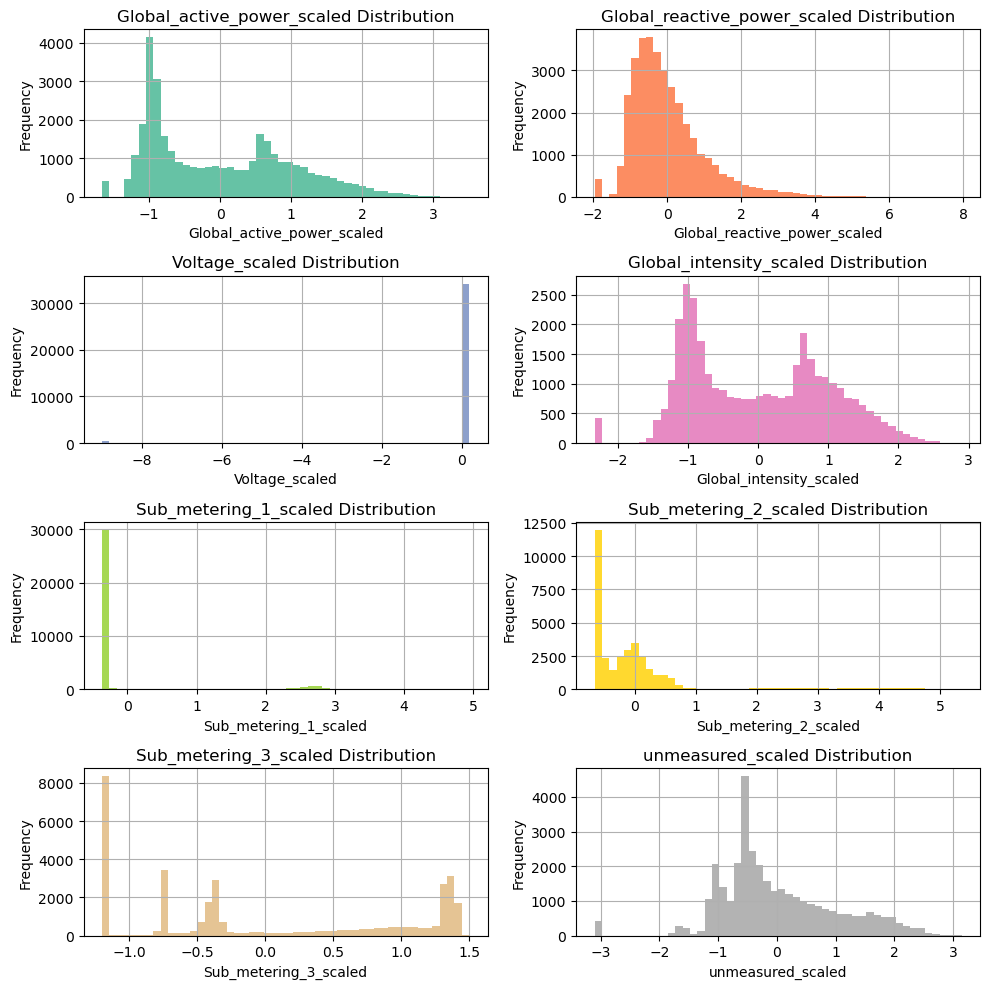

In [26]:
colors = sns.color_palette("Set2", len(df_transformed.columns))

plots_per_row = 2

num_rows = len(df_transformed.columns) // plots_per_row + (len(df_transformed.columns) % plots_per_row > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(10, 10))

axes = axes.flatten()

for i, (col, color) in enumerate(zip(df_transformed.columns, colors)):
    df_transformed[col].hist(bins=50, ax=axes[i], color=color)
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()